### Mask-RCNN DataLoader. Balloon dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../src')

from samples.balloon import balloon
from preprocess import preprocess
from preprocess import augmentation as aug

%matplotlib inline

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2021-09-25T15:23:56.371384+03:00

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-65-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

matplotlib: 3.2.2
numpy     : 1.18.5



We set paths to train and val parts of balloon dataset 

In [3]:
base_dir = os.getcwd().replace('src', 'balloon')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
from common.config import CONFIG

In `common.config` you can inspect general Mask-RCNN config as a dict

In [6]:
CONFIG.update(balloon.BALLOON_CONFIG)
CONFIG

{'image_shape': (512, 512, 3),
 'img_size': 512,
 'backbone': 'mobilenet',
 'meta_shape': 14,
 'num_classes': 2,
 'class_dict': {'balloon': 1, 'background': 0},
 'normalization': {'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'image_min_dim': 300,
 'image_min_scale': 0,
 'image_max_dim': 512,
 'image_resize_mode': 'square',
 'use_mini_masks': False,
 'mini_mask_shape': (32, 32),
 'mask_shape': (28, 28),
 'epochs': 100,
 'gpu_num': 1,
 'batch_size': 1,
 'images_per_gpu': 1,
 'training': True,
 'log_per_steps': 5,
 'use_multiprocessing': True,
 'workers': 6,
 'callback': {'checkpoints_dir': '../logs/scalars',
  'reduce_lr_on_plateau': 0.98,
  'reduce_lr_on_plateau_patience': 10,
  'save_weights_only': True,
  'save_best_only': True,
  'histogram_freq': 0,
  'profile_batch': '1,2'},
 'backbone_strides': [4, 8, 16, 32, 64],
 'top_down_pyramid_size': 256,
 'rpn_anchor_scales': (32, 64, 128, 256, 512),
 'rpn_anchor_ratios': [0.5, 1, 2],
 'rpn_anchor_stride': 1,
 'rpn_train

---
For dataset preparation first we create train and validation instances of __BalloonDataset__.
__BalloonDataset__ inherits all the functions from the base __SegmentationDataset__ class in `/src/common/preprocess/preprocess.py` which was prepared for VGG Image Annotation tool. 
Hovewer, some details of annotations can be different as in balloon dataset annotation so we made `BalloonDataset` class.

__SegmentationDataset__ (__BalloonDataset__) also includes arguments for data augmentation and normalization if necessary. An example of training augmentation is in `/src/common/preprocess/augmentation.py`.
For augmentation we use very flexible __albumentations__ library.

Then we pass __BalloonDataset__ to __DataLoader__ class which inherits tf.keras.utils.Sequence functionality for Mask-RCNN model.

In [7]:
train_dataset = balloon.BalloonDataset(images_dir=train_dir,
                                       class_key='object',
                                       classes_dict=CONFIG['class_dict'],
                                       preprocess_transform=preprocess.get_input_preprocess(
                                           normalize=CONFIG['normalization']
                                       ),
                                       augmentation=aug.get_training_augmentation(),
                                       json_annotation_key=None,
                                       **CONFIG
                                            )

val_dataset = balloon.BalloonDataset(images_dir=val_dir,
                                     class_key='object',
                                     classes_dict=CONFIG['class_dict'],
                                     preprocess_transform=preprocess.get_input_preprocess(
                                         normalize=CONFIG['normalization']
                                     ),
                                     json_annotation_key=None,
                                     **CONFIG
                                    )

# cast_output=False here is only to avoid gpu memory allocation in tensorflow casting
train_dataloader = preprocess.DataLoader(train_dataset,
                                         shuffle=True,
                                         cast_output=False,
                                         **CONFIG
                                        )
val_dataloader = preprocess.DataLoader(val_dataset,
                                       shuffle=False,
                                       cast_output=False,
                                       **CONFIG
                                      )

Found annotation file: via_region_data.json in dataset path: /home/alexander/Documents/py_projects/github/maskrcnn_tf2/balloon/train
Found annotation file: via_region_data.json in dataset path: /home/alexander/Documents/py_projects/github/maskrcnn_tf2/balloon/val
dataloader DataLoader. Steps per epoch: 61
dataloader DataLoader. Steps per epoch: 13


Create data generators for training and validation

In [8]:
train_iterated = iter(train_dataloader)
val_iterated = iter(val_dataloader)

In [15]:
"""
inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
outputs = []
"""
train_batch = next(train_iterated)

Inspect batch shapes

In [16]:
batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,\
batch_gt_class_ids, batch_gt_boxes, batch_gt_masks = train_batch[0]

for x in train_batch[0]:
    print(x.shape)

(1, 512, 512, 3)
(1, 14)
(1, 65472, 1)
(1, 256, 4)
(1, 100)
(1, 100, 4)
(1, 512, 512, 100)


Inspect train and validation image examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


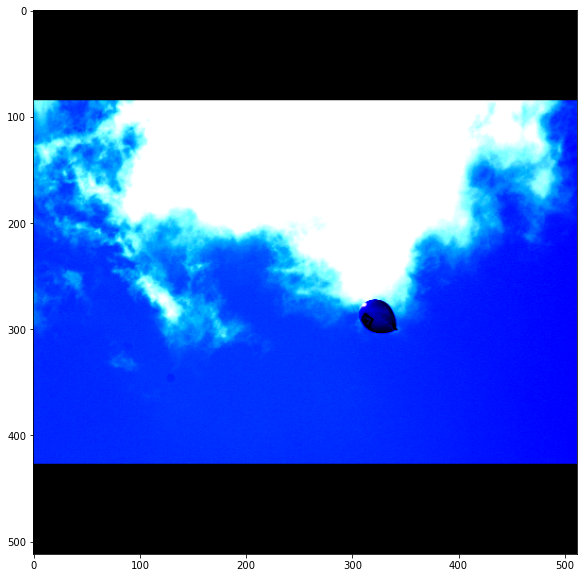

In [17]:
for img in batch_images:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img)

In [20]:
batch_gt_masks.shape

(1, 512, 512, 100)

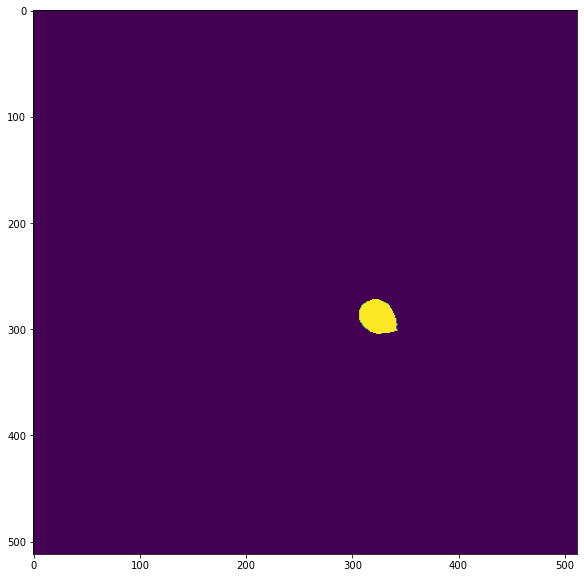

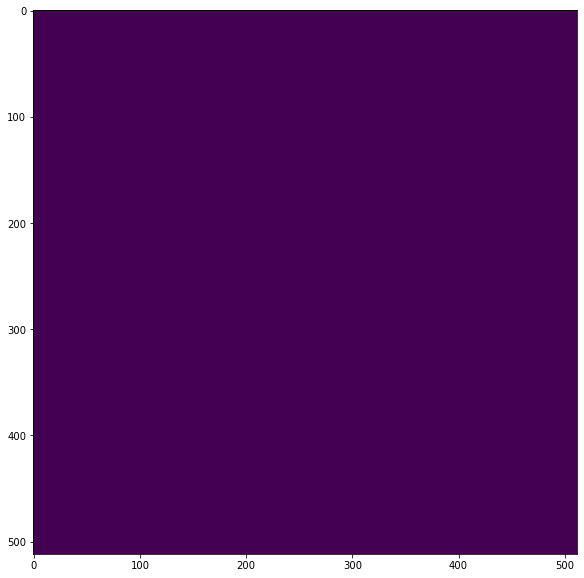

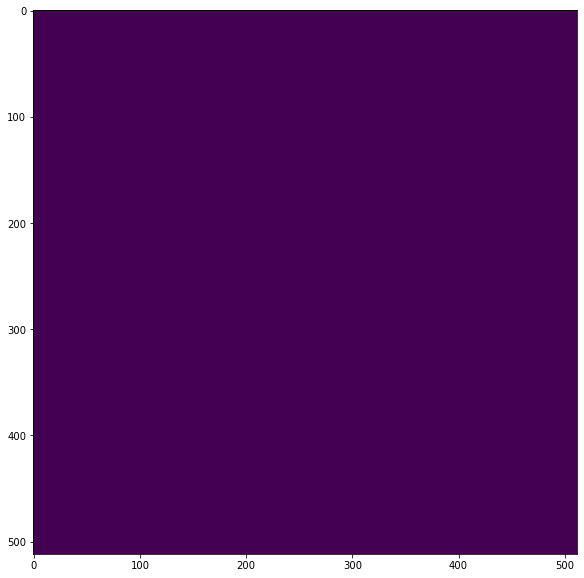

In [18]:
show_masks = 3
for mask in np.moveaxis(batch_gt_masks[0], -1, 0)[:show_masks]:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(mask)

In [21]:
val_batch = next(val_iterated)

val_batch_images, val_batch_image_meta, val_batch_rpn_match, val_batch_rpn_bbox,\
val_batch_gt_class_ids, val_batch_gt_boxes, val_batch_gt_masks = val_batch[0]

for x in val_batch[0]:
    print(x.shape)

(1, 512, 512, 3)
(1, 14)
(1, 65472, 1)
(1, 256, 4)
(1, 100)
(1, 100, 4)
(1, 512, 512, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


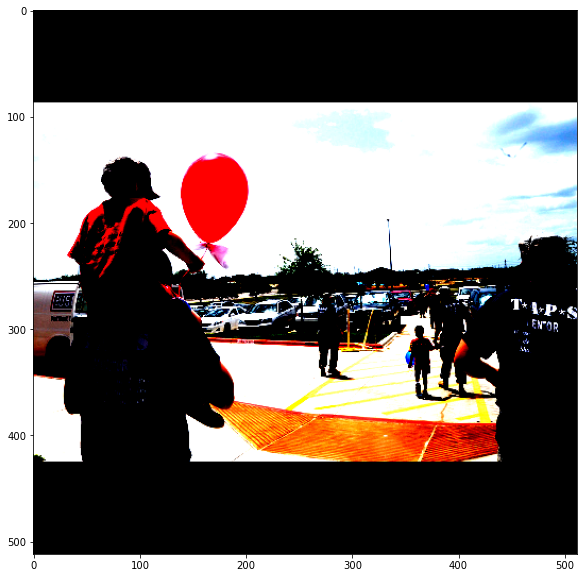

In [22]:
for img in val_batch_images:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img )

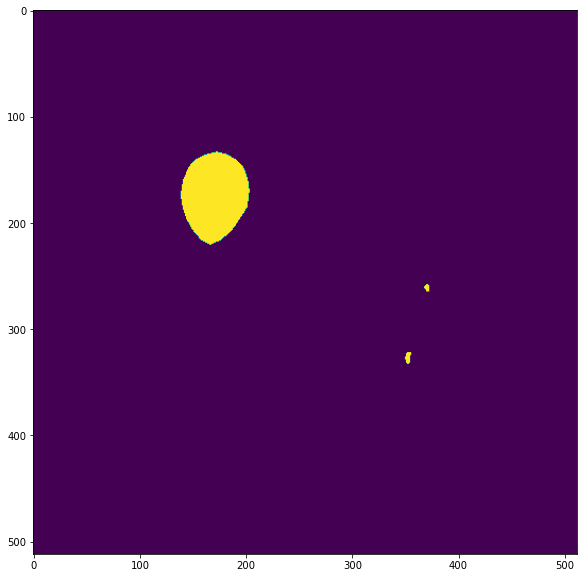

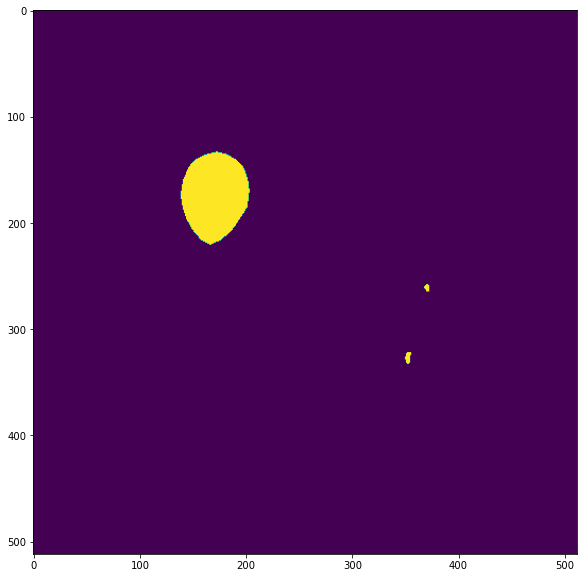

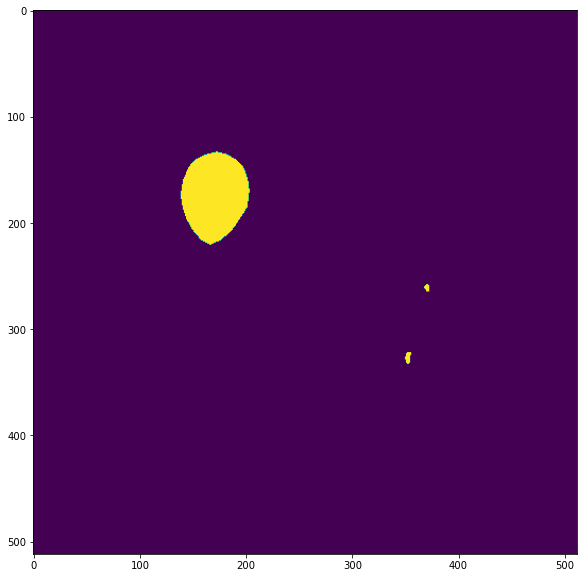

In [23]:
show_masks = 3
for mask in np.moveaxis(val_batch_gt_masks[0], -1, 0)[:show_masks]:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(mask)